<IPython.core.display.Javascript object>


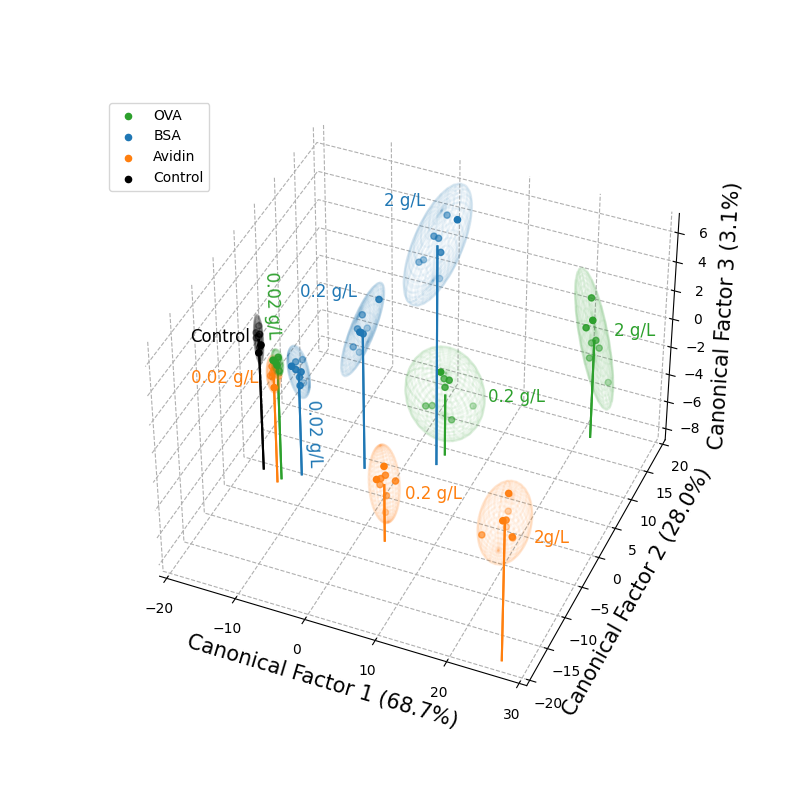

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.linalg as la
import matplotlib

DataFilePath = "../TrainingData/SensorArrayProteinResponseMatrixPairwiseAveraging.csv"

# features:
#   - current density used to fabricate sensors, correlated with pore size {55mAcm^-2, 40mAcm^-2, 25mAcm^-2}
#   - pH of buffer used to make protein solutions {pH4, pH10}
features = ['55mAcm^-2pH4','55mAcm^-2pH10','40mAcm^-2pH4','40mAcm^-2pH10','25mAcm^-2pH4','25mAcm^-2pH10']

# load dataset into Pandas DataFrame
df = pd.read_csv(DataFilePath, header=0)

# load data and labels
x = df.loc[:, features].values
y = df.loc[:,['Labels']].values
y = np.transpose(y)[0,]

# standardizing the data
x = StandardScaler().fit_transform(x)

# apply linear discriminant analysis, to find linear combinations of original features that maximise the ratio of
# between class to within class variance
model = LinearDiscriminantAnalysis(n_components=3, tol=1e-3, solver = 'svd')
LinearDiscriminants = model.fit_transform(x, y)

# discriminatory power described by each linear discriminant (aka canonical factor)
explained_variance = np.round_(model.explained_variance_ratio_*100, decimals = 1)

# load data transformed by linear discriminant analysis into dataframe
LinearDiscriminantsdf = pd.DataFrame(data = LinearDiscriminants
             , columns = ['linear discriminant 1', 'linear discriminant 2', 'linear discriminant 3'])

# add experimental conditions label to each example in the dataframe
LabelledLinearDiscriminantsdf = pd.concat([LinearDiscriminantsdf, df[['ExperimentalConditions']]], axis = 1)

fig = plt.figure(figsize = (8,8))
plt.rcParams["grid.linestyle"]="dashed"
ax = fig.add_subplot(111, projection = '3d')

# include the discriminatory power described by each linear discriminant (aka canonical factor) in each axis label
ax.set_xlabel('Canonical Factor 1 (' + str(explained_variance[0]) + '%)', fontsize = 15)
ax.set_ylabel('Canonical Factor 2 (' + str(explained_variance[1]) + '%)', fontsize = 15)
ax.set_zlabel('Canonical Factor 3 (' + str(explained_variance[2]) + '%)', fontsize = 15)

targets = ['COA0.02', 'COA0.2','COA2', 'BSA0.02','BSA0.2', 'BSA2', 'AV0.02', 'AV0.2','AV2', 'Cntrl']
colors = ['tab:green', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue','tab:blue', 'tab:orange', 'tab:orange', 'tab:orange', 'k']
labels = ['OVA', 'BSA', 'Avidin', 'Control']

# initialise spherical coordinate azimuth angle (u) and polar angle (v)
u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)
labelindex=0
for target, color in zip(targets,colors):
    
    # identify indices of rows containing examples corresponding to the current target protein concentration
    indicesToKeep = LabelledLinearDiscriminantsdf['ExperimentalConditions'] == target
    
    # mean of each protein concentration cluster
    Means = LinearDiscriminantsdf.loc[indicesToKeep].mean()
    
    ax.stem([Means[0], Means[0]], [Means[1], Means[1]], [Means[2], Means[2]]
             , linefmt = color
             , markerfmt = color
             , basefmt = " "
             , bottom = -8.5
             , label=None)
    
    # only add the legend (protein name) for the first concentration of each protein or control
    if((target == 'COA0.02')|(target == 'BSA0.02')|(target == 'AV0.02')|(target == 'Cntrl')):
        ax.scatter(LabelledLinearDiscriminantsdf.loc[indicesToKeep, 'linear discriminant 1']
                   , LabelledLinearDiscriminantsdf.loc[indicesToKeep, 'linear discriminant 2']
                   , LabelledLinearDiscriminantsdf.loc[indicesToKeep, 'linear discriminant 3']
                   , c = color
                   , label=labels[labelindex])
        labelindex+=1
    else:      
        ax.scatter(LabelledLinearDiscriminantsdf.loc[indicesToKeep, 'linear discriminant 1']
                   , LabelledLinearDiscriminantsdf.loc[indicesToKeep, 'linear discriminant 2']
                   , LabelledLinearDiscriminantsdf.loc[indicesToKeep, 'linear discriminant 3']
                   , c = color
                   , label=None)
    
    ## calculate and plot confidence interval ellipsoids for each protein concentration cluster
    
    # subtract mean from each protein concentration cluster
    means = LinearDiscriminantsdf[indicesToKeep].mean()
    LinearDiscriminantsdf[indicesToKeep] = (LinearDiscriminantsdf[indicesToKeep] - LinearDiscriminantsdf[indicesToKeep].mean()) 
    
    # calculate the covariance matrix of the data points for each protein concentration cluster
    cov  = np.cov(LinearDiscriminantsdf.loc[indicesToKeep,:].values, rowvar=False)
    
    # find the eigenvalues and eigenvectors of the covariance matrix for each concentration cluster
    eigval, eigvec = np.linalg.eig(cov)
    
    # define an ellipsoid using parametric equations expressing cartesian coordinates in terms of the spherical coordinate
    # angles u and v. assuming clusters are multivariate normally distributed, in any given direction the distribution is
    # chi squared (chi squared values = 95%: 7.815, 97.5%: 9.348, 99%: 11.345)
    x = np.sqrt(eigval[0] * 7.815) * np.outer(np.cos(u), np.sin(v))
    y = np.sqrt(eigval[1] * 7.815) * np.outer(np.sin(u), np.sin(v))
    z = np.sqrt(eigval[2] * 7.815) * np.outer(np.ones_like(u), np.cos(v))
    
    # define grid of points on surface of ellispoid to plot wireframe
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j], y[i,j], z[i,j]] = np.transpose(np.matmul(eigvec, [x[i,j], y[i,j], z[i,j]])) + means
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=color, alpha=0.05)

ax.legend(loc='upper left')
ax.set_xlim(-20,30)
ax.set_ylim(-20,20)
ax.set_zlim(-8.5,7)

# set 3D viewing azimuth and elevation angles
ax.view_init(elev=40., azim=-67)

# manually specify text on plot labelling different clusters
ax.text(-17, -1, 1, '0.02 g/L', 'z', fontsize = 'large', color = 'tab:green')
ax.text(10, 10, -4.5, '0.2 g/L', fontsize = 'large', color = 'tab:green')
ax.text(24, 18, -1, '2 g/L', fontsize = 'large', color = 'tab:green')
ax.text(-9.5, -4, -6, '0.02 g/L','z', fontsize = 'large', color = 'tab:blue')
ax.text(-13, 2, 3, '0.2 g/L', fontsize = 'large', color = 'tab:blue')
ax.text(-3, 6, 9, '2 g/L', fontsize = 'large', color = 'tab:blue')
ax.text(-24, -7, -1, '0.02 g/L', fontsize = 'large', color = 'tab:orange')
ax.text(9, -11, -3, '0.2 g/L', fontsize = 'large', color = 'tab:orange')
ax.text(31, -20, 1, '2g/L', fontsize = 'large', color = 'tab:orange')
ax.text(-25, -5, 1, 'Control', fontsize = 'large', color = 'k')

# set background colour to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.savefig("../Figures/LDA_3DPlot_PairwiseAveraging.png", dpi=200, bbox_inches='tight')